# Toronto Restaurant Traffic During the Covid-19 Pandemic

After coming across this [OpenTable Dataset](https://www.opentable.com/state-of-industry) of year-over-year comparisons of restaurant reservations over the last couple of months, as well as [Google's Community Mobility Reports](https://www.google.com/covid19/mobility/) I wanted to see how Toronto is fairing during this pandemic and compare it to other Canadian cities.

### Summary of Insights
* The Data for Toronto is correlated with other Canadian cities, but most closely correlated to Montreal.
* Toronto's Mobility Report Data for the Retail and Recreation category is correlated Restaurant reservations, as expected.
* Proximity data for the Retail and Recreation category is most closely correlated with proximity to transit stations in Toronto.
* Forecast from Google Community Mobility Reports shows a return to normal levels by around November of this year.
* Forecast from Toronto's OpenTable data shows a return to normal levels by December.
* The slope of the recovery trendlines for cities in the OpenTable data shows clear differences in the "eagerness to return" of different cities, perhaps dictated by economic reactivation policies.

First we import pandas and Facebook Prophetto find trendlines for the data, and load the OpenTable data for reservations by city.

In [2]:
import pandas as pd
from fbprophet import Prophet
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
opentable_df = pd.read_csv('~/Desktop/Data/Opentable_cities.csv')

In [4]:
opentable_df.head()

,Date,Atlanta,Austin,Baltimore,Boston,Calgary,Charlotte,Chicago,Cincinnati,Ciudad de México,...,San Antonio,San Diego,San Francisco,San Pedro Garza García,Scottsdale,Seattle,Tampa,Toronto,Vancouver,Washington
0,2/18/2020,6.0,0.0,10.0,5.0,0.0,1.0,-7.0,7.0,-8.0,...,-6.0,-1.0,-15.0,-9.0,-3.0,8.0,7.0,-14.0,9.0,-5.0
1,2/19/2020,9.0,-6.0,42.0,15.0,4.0,-3.0,-3.0,1.0,-9.0,...,-4.0,9.0,-11.0,-12.0,-3.0,11.0,5.0,-8.0,1.0,57.0
2,2/20/2020,-5.0,2.0,12.0,-3.0,5.0,-27.0,-5.0,-6.0,-2.0,...,-5.0,7.0,-4.0,-5.0,5.0,6.0,2.0,-9.0,7.0,9.0
3,2/21/2020,-5.0,3.0,-9.0,-12.0,0.0,-1.0,-4.0,-6.0,-3.0,...,2.0,-1.0,-8.0,4.0,6.0,1.0,-4.0,-9.0,6.0,0.0
4,2/22/2020,-3.0,2.0,12.0,-2.0,11.0,0.0,7.0,-8.0,0.0,...,-6.0,-12.0,-9.0,10.0,-5.0,1.0,11.0,-4.0,7.0,9.0


I wanted to quickly see what cities where most closely correlated with Toronto using .corr() (Pearson correlation).
Montreal, Boston, and Portland were the cities most closely correlated to Toronto in reservation behaviour during this time. Naples and Munich differed the most.

In [5]:
opentable_df.corr().Toronto.sort_values(ascending = False)

Toronto                   1.000000
Montréal                  0.959674
Boston                    0.957542
Portland                  0.946359
Ciudad de México          0.939809
Chicago                   0.936859
Vancouver                 0.933328
Philadelphia              0.932112
London                    0.926760
Atlanta                   0.925992
Raleigh                   0.924980
Baltimore                 0.922865
Nashville                 0.922238
Denver                    0.919447
Washington                0.918916
San Diego                 0.916568
Louisville                0.915947
Minneapolis               0.912599
Orlando                   0.909955
Dallas                    0.909481
Indianapolis              0.905318
Pittsburgh                0.900589
Las Vegas                 0.897184
Los Angeles               0.895185
Austin                    0.891701
Columbus                  0.888017
Calgary                   0.885670
New York                  0.877774
Charlotte           

## Facebook Prophet

I want to plot the curve for Toronto and make a trendline with Facebook Prophet.
For Prophet to work I had to create a dataframe of two columns, 'Date' and 'Toronto'.

In [6]:
to_df = opentable_df[['Date', 'Toronto']]

In [7]:
to_df.head()

,Date,Toronto
0,2/18/2020,-14.0
1,2/19/2020,-8.0
2,2/20/2020,-9.0
3,2/21/2020,-9.0
4,2/22/2020,-4.0


In [8]:
to_df.set_index('Date')

,Toronto
Date,
2/18/2020,-14.00
2/19/2020,-8.00
2/20/2020,-9.00
2/21/2020,-9.00
2/22/2020,-4.00
...,...
9/9/2020,-62.78
9/10/2020,-58.63
9/11/2020,-49.04


In [9]:
# Change the type of the Date column to datetime

to_df.loc[:, 'Date'] = pd.to_datetime(to_df['Date'])

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Below I plotted the curve showing the y-o-y change in reservations for Toronto restaurants in OpenTable. I want to make a simple forecast with Prophet to estimate when things could be back to normal levels.

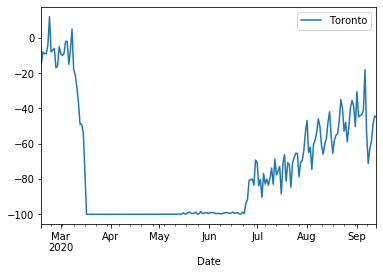

In [10]:
to_df.plot(x='Date', y='Toronto')

In [11]:
# Renaming columns for fbprophet to work

to_df = to_df.rename(columns = {'Date': 'ds', 'Toronto': 'y'})

In [12]:
# Fitting the model and making the predictions.

m = Prophet()
m.fit(to_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [13]:
future = m.make_future_dataframe(periods=100)
future.tail()

,ds
304,2020-12-18
305,2020-12-19
306,2020-12-20
307,2020-12-21
308,2020-12-22


In [14]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
304,2020-12-18,11.724509,-27.189961,48.570927
305,2020-12-19,14.379137,-24.313969,51.061043
306,2020-12-20,15.371193,-24.615263,53.817119
307,2020-12-21,10.640020,-30.922358,48.441468
308,2020-12-22,10.989532,-27.511839,48.904796


Below I protted the forecast. If things continue according to this trend, maybe things will go back to normal levels in Toronto by the end of the year.

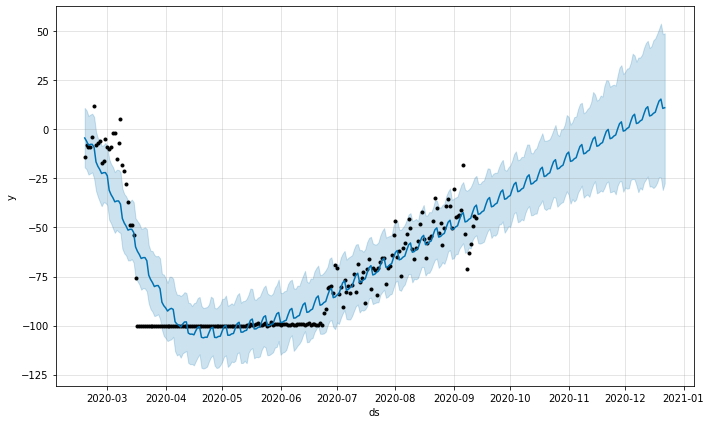

In [15]:
fig1 = m.plot(forecast)

# Seasonality

fbprophet allows you to see the components of the forecast, the second graph below shows the seasonality of the curve. Weekly we expect greater values from Thursday to Sunday. 

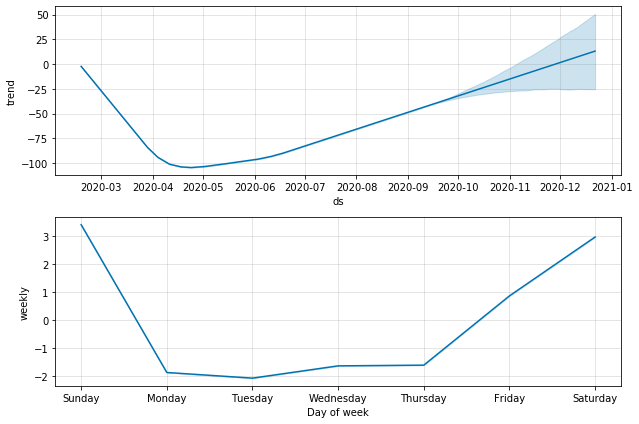

In [16]:
fig2 = m.plot_components(forecast)


### Google Community Reports

Next, I wanted to explore the Google Community Mobility Reports, which shows users' proximity to locations of different categories. I'm particularily interested in the "Retail and Recreation" category, which includes proximity to restaurants.

In [17]:
# Loading the data and separating the data for Toronto

google_cmr = pd.read_csv('~/Desktop/DataScience/Datasets/Global_Mobility_Report.csv', low_memory = False)
gmr_to = google_cmr.loc[google_cmr['sub_region_2'] == 'Toronto Division']

In [18]:
gmr_to.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
588703,CA,Canada,Ontario,Toronto Division,NaN,NaN,NaN,2020-02-15,0.0,2.0,15.0,1.0,0.0,-1.0
588704,CA,Canada,Ontario,Toronto Division,NaN,NaN,NaN,2020-02-16,11.0,10.0,35.0,8.0,-4.0,-3.0
588705,CA,Canada,Ontario,Toronto Division,NaN,NaN,NaN,2020-02-17,-26.0,-45.0,49.0,-50.0,-76.0,17.0
588706,CA,Canada,Ontario,Toronto Division,NaN,NaN,NaN,2020-02-18,-3.0,11.0,-2.0,1.0,-1.0,0.0
588707,CA,Canada,Ontario,Toronto Division,NaN,NaN,NaN,2020-02-19,-1.0,3.0,-3.0,-2.0,0.0,1.0


In [19]:
# Reducing the dataframe to only the columns I'm interested in

wanted_columns = ['date', 'retail_and_recreation_percent_change_from_baseline',\
                          'parks_percent_change_from_baseline', 'workplaces_percent_change_from_baseline',\
                          'transit_stations_percent_change_from_baseline', 'residential_percent_change_from_baseline',\
                 'grocery_and_pharmacy_percent_change_from_baseline']

gmr_to = gmr_to[wanted_columns]

In [20]:
gmr_to.head()

,date,retail_and_recreation_percent_change_from_baseline,parks_percent_change_from_baseline,workplaces_percent_change_from_baseline,transit_stations_percent_change_from_baseline,residential_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline
588703,2020-02-15,0.0,15.0,0.0,1.0,-1.0,2.0
588704,2020-02-16,11.0,35.0,-4.0,8.0,-3.0,10.0
588705,2020-02-17,-26.0,49.0,-76.0,-50.0,17.0,-45.0
588706,2020-02-18,-3.0,-2.0,-1.0,1.0,0.0,11.0
588707,2020-02-19,-1.0,-3.0,0.0,-2.0,1.0,3.0


In [21]:
# Changing the type of the date column to datetime and setting it as the index

gmr_to.loc[:, 'date'] = pd.to_datetime(gmr_to['date'])

In [22]:
gmr_to.set_index('date')

,retail_and_recreation_percent_change_from_baseline,parks_percent_change_from_baseline,workplaces_percent_change_from_baseline,transit_stations_percent_change_from_baseline,residential_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline
date,,,,,,
2020-02-15,0.0,15.0,0.0,1.0,-1.0,2.0
2020-02-16,11.0,35.0,-4.0,8.0,-3.0,10.0
2020-02-17,-26.0,49.0,-76.0,-50.0,17.0,-45.0
2020-02-18,-3.0,-2.0,-1.0,1.0,0.0,11.0
2020-02-19,-1.0,-3.0,0.0,-2.0,1.0,3.0
...,...,...,...,...,...,...
2020-08-26,-26.0,64.0,-52.0,-53.0,16.0,-9.0
2020-08-27,-24.0,104.0,-51.0,-51.0,15.0,-1.0
2020-08-28,-26.0,100.0,-50.0,-47.0,14.0,-5.0


## Facebook Prophet Trendline

I wanted to do the same thing with the retail proximity data for Toronto, to plot the curve and then plot a trendline to estimate when things will go back to normal levels. 

In [23]:
gmr = gmr_to[['date', 'retail_and_recreation_percent_change_from_baseline']]
gmr = gmr.rename(columns = {'date': 'ds', 'retail_and_recreation_percent_change_from_baseline': 'y'})

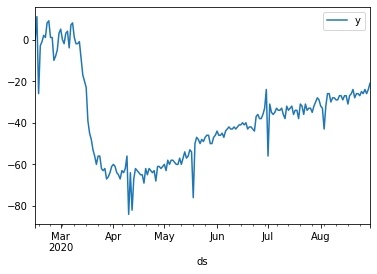

In [24]:
# Plotting the curve showing the change in proximity to locations of the Retail and Recreation category since the start of the pandemic

gmr.plot(x='ds', y='y')

In [25]:
n = Prophet()
n.fit(gmr)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [26]:
future = n.make_future_dataframe(periods=100)
future.tail()

,ds
293,2020-12-04
294,2020-12-05
295,2020-12-06
296,2020-12-07
297,2020-12-08


In [27]:
forecast2 = n.predict(future)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
293,2020-12-04,7.834950,-16.547186,30.871932
294,2020-12-05,9.628009,-14.354526,33.877969
295,2020-12-06,9.949772,-15.278835,35.013265
296,2020-12-07,8.547261,-16.669456,30.222507
297,2020-12-08,11.247047,-14.436279,35.247941


Below I plotted the prediction for the curve of proximity data to the Retail and Recreation category. 
This trendline shows that things could go back to normal by November of this year, sooner than the prediction we made for the OpenTable data.

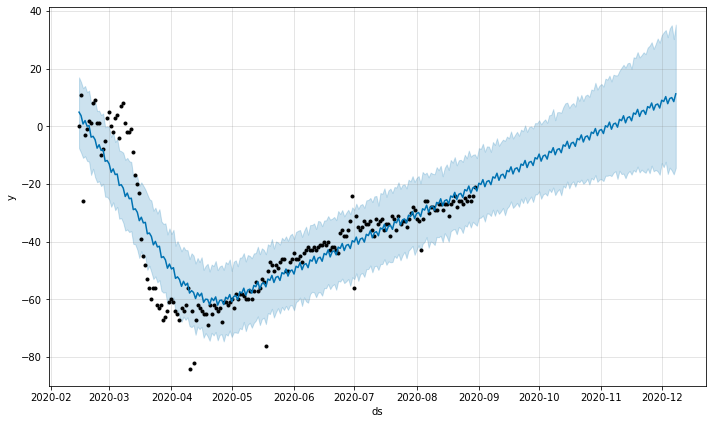

In [28]:
fig1 = n.plot(forecast2)

# Seasonality

The seasonalities for the OpenTable and Google Proximity Reports are similar (as expected), showing greated values between Thursday and Sunday.

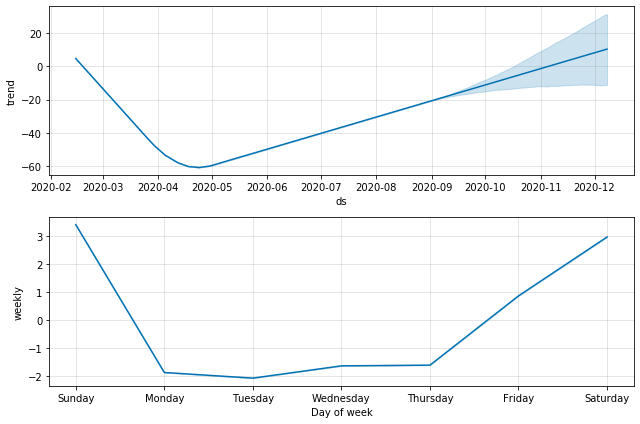

In [29]:
fig2 = m.plot_components(forecast2)

## Comparing Canadian Cities

I wanted to compare the Community Mobility Reports for the Canadian cities included in the OpenTable dataset. 

In [30]:
canada_df = google_cmr.loc[ 
    
#Selecting the Canadian cities
    
    (
                           (google_cmr['sub_region_1'] == 'Alberta') & (
                           (google_cmr['sub_region_2'] == 'Division No. 6 - Calgary') )
    
    ) |
    
    (
                           (google_cmr['sub_region_1'] == 'Ontario') & (
                           (google_cmr['sub_region_2'] == 'Toronto Division') )
    
    ) |
    
        (
                           (google_cmr['sub_region_1'] == 'Quebec') & (
                           (google_cmr['sub_region_2'] == 'Montreal') )

        
    ) |
    
            (
                           (google_cmr['sub_region_1'] == 'British Columbia') & (
                           (google_cmr['sub_region_2'] == 'Metro Vancouver') )

        
    ) |
    
    (
                           (google_cmr['sub_region_1'] == 'Alberta') & (
                           (google_cmr['sub_region_2'] == 'Division No. 11 - Edmonton') )

        
    ) 


]

In [31]:
canada_df.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
561574,CA,Canada,Alberta,Division No. 11 - Edmonton,NaN,NaN,NaN,2020-02-15,5.0,2.0,18.0,8.0,-2.0,-1.0
561575,CA,Canada,Alberta,Division No. 11 - Edmonton,NaN,NaN,NaN,2020-02-16,8.0,-3.0,5.0,8.0,-3.0,-2.0
561576,CA,Canada,Alberta,Division No. 11 - Edmonton,NaN,NaN,NaN,2020-02-17,-4.0,1.0,-4.0,-36.0,-70.0,17.0
561577,CA,Canada,Alberta,Division No. 11 - Edmonton,NaN,NaN,NaN,2020-02-18,-3.0,-1.0,-21.0,-10.0,-8.0,3.0
561578,CA,Canada,Alberta,Division No. 11 - Edmonton,NaN,NaN,NaN,2020-02-19,9.0,8.0,33.0,-4.0,1.0,0.0


In [32]:
# Creating a new dataframe with only the columns we need

wanted_columns = ['date', 'sub_region_2', 'retail_and_recreation_percent_change_from_baseline',\
                          'parks_percent_change_from_baseline', 'workplaces_percent_change_from_baseline',\
                          'transit_stations_percent_change_from_baseline', 'residential_percent_change_from_baseline',\
                 'grocery_and_pharmacy_percent_change_from_baseline']

canada_df = canada_df[wanted_columns]

In [33]:
canada_df.head()

,date,sub_region_2,retail_and_recreation_percent_change_from_baseline,parks_percent_change_from_baseline,workplaces_percent_change_from_baseline,transit_stations_percent_change_from_baseline,residential_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline
561574,2020-02-15,Division No. 11 - Edmonton,5.0,18.0,-2.0,8.0,-1.0,2.0
561575,2020-02-16,Division No. 11 - Edmonton,8.0,5.0,-3.0,8.0,-2.0,-3.0
561576,2020-02-17,Division No. 11 - Edmonton,-4.0,-4.0,-70.0,-36.0,17.0,1.0
561577,2020-02-18,Division No. 11 - Edmonton,-3.0,-21.0,-8.0,-10.0,3.0,-1.0
561578,2020-02-19,Division No. 11 - Edmonton,9.0,33.0,1.0,-4.0,0.0,8.0


In [34]:
# I exported the csv to see if I could come up with nicer visualizations on Tableau

canada_df.to_csv('~/Desktop/canadagcmb.csv', index=False)

## Correlations 

For Canadian cities we see that there is a fair correlation for proximity to transit stations and grocery & pharmacy to retail and recration.

In [35]:
canada_df.corr()

,retail_and_recreation_percent_change_from_baseline,parks_percent_change_from_baseline,workplaces_percent_change_from_baseline,transit_stations_percent_change_from_baseline,residential_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline
retail_and_recreation_percent_change_from_baseline,1.000000,0.196134,0.701152,0.819159,-0.774004,0.838451
parks_percent_change_from_baseline,0.196134,1.000000,0.089307,0.046791,-0.282497,0.205352
workplaces_percent_change_from_baseline,0.701152,0.089307,1.000000,0.892031,-0.938557,0.470960
transit_stations_percent_change_from_baseline,0.819159,0.046791,0.892031,1.000000,-0.854361,0.574114
residential_percent_change_from_baseline,-0.774004,-0.282497,-0.938557,-0.854361,1.000000,-0.518294
grocery_and_pharmacy_percent_change_from_baseline,0.838451,0.205352,0.470960,0.574114,-0.518294,1.000000


In [36]:
retail_df = canada_df.pivot(index='date', columns='sub_region_2', values = 'retail_and_recreation_percent_change_from_baseline')

# Similar Cities

Comparing proximity data for Retail and Recreation we see that Toronto is most closely correlated to Montreal and Vancouver, and least so to Edmonton. All of these Canadian cities are fairly correlated with each other.

In [37]:
retail_df.corr()

sub_region_2,Division No. 11 - Edmonton,Division No. 6 - Calgary,Metro Vancouver,Montreal,Toronto Division
sub_region_2,,,,,
Division No. 11 - Edmonton,1.000000,0.974243,0.938366,0.884933,0.885786
Division No. 6 - Calgary,0.974243,1.000000,0.952106,0.927950,0.913863
Metro Vancouver,0.938366,0.952106,1.000000,0.952656,0.955044
Montreal,0.884933,0.927950,0.952656,1.000000,0.962485
Toronto Division,0.885786,0.913863,0.955044,0.962485,1.000000


Another Tableau Visualization, for the Retail and Recreation category in Canadian cities.

## Comparing the OpenTable data for Toronto with the Google Proximity data

In [38]:
toronto_opentable = opentable_df[['Date', 'Toronto']]
toronto_opentable = toronto_opentable.rename(columns = {'Date': 'date'})

In [39]:
# setting the date column to datetime

toronto_opentable.loc[:,'date'] = pd.to_datetime(toronto_opentable['date'])

In [40]:
toronto_opentable.dtypes

date       datetime64[ns]
Toronto           float64
dtype: object

I created masks to select a date range that would match for both datasets.

In [41]:
mask = (toronto_opentable['date'] >= '2020-02-18') & (toronto_opentable['date'] <= '2020-08-30')
mask2 = (gmr_to['date'] >= '2020-02-18') & (gmr_to['date'] <= '2020-08-30')

In [42]:
toronto_opentable = toronto_opentable.loc[mask]
gmr_to = gmr_to.loc[mask2]

In [43]:
toronto_opentable = toronto_opentable.set_index('date')
gmr_to = gmr_to.set_index('date')

In [44]:
toronto_opentable = toronto_opentable.rename(columns = {'Toronto' : 'restaurant_reservations_yoy_percent'})

In [45]:
# Merging the two Toronto dataframes

df = pd.concat([toronto_opentable, gmr_to], axis = 1)

In [46]:
df.head()

,restaurant_reservations_yoy_percent,retail_and_recreation_percent_change_from_baseline,parks_percent_change_from_baseline,workplaces_percent_change_from_baseline,transit_stations_percent_change_from_baseline,residential_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline
date,,,,,,,
2020-02-18,-14.0,-3.0,-2.0,-1.0,1.0,0.0,11.0
2020-02-19,-8.0,-1.0,-3.0,0.0,-2.0,1.0,3.0
2020-02-20,-9.0,2.0,2.0,2.0,-1.0,0.0,5.0
2020-02-21,-9.0,1.0,20.0,-6.0,2.0,2.0,-1.0
2020-02-22,-4.0,8.0,56.0,7.0,13.0,-1.0,8.0


# More Correlations

Below we see that the year-over-year change in restaurant reservations for Toronto is correlated with the proximity change for the Retail and Recreation category and Transit Stations. 

In [47]:
df.corr()

,restaurant_reservations_yoy_percent,retail_and_recreation_percent_change_from_baseline,parks_percent_change_from_baseline,workplaces_percent_change_from_baseline,transit_stations_percent_change_from_baseline,residential_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline
restaurant_reservations_yoy_percent,1.000000,0.911027,0.207520,0.750875,0.896594,-0.764805,0.631792
retail_and_recreation_percent_change_from_baseline,0.911027,1.000000,0.367985,0.770879,0.907689,-0.791346,0.854525
parks_percent_change_from_baseline,0.207520,0.367985,1.000000,0.264092,0.222749,-0.424965,0.336558
workplaces_percent_change_from_baseline,0.750875,0.770879,0.264092,1.000000,0.933953,-0.958992,0.598141
transit_stations_percent_change_from_baseline,0.896594,0.907689,0.222749,0.933953,1.000000,-0.895810,0.702946
residential_percent_change_from_baseline,-0.764805,-0.791346,-0.424965,-0.958992,-0.895810,1.000000,-0.601109
grocery_and_pharmacy_percent_change_from_baseline,0.631792,0.854525,0.336558,0.598141,0.702946,-0.601109,1.000000


In [48]:
# Moving to csv to create visualizations on Tableau


df.to_csv('~/Desktop/toronto.csv', index = True)